### **Data Extraction**

In [7]:
import zipfile
import os

# Define the path to the zip file and the extraction directory
zip_path = "/content/drive/MyDrive/Dataset.zip"
extract_path = "/content/Dataset"

# Create the extraction directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Dataset extracted to: {extract_path}")

# List the contents of the extracted directory
extracted_dir_path = '/content/Dataset'
if os.path.exists(extracted_dir_path):
    print(f"\nContents of {extracted_dir_path}:")
    for item in os.listdir(extracted_dir_path):
        print(item)

# List the contents of the images subdirectory
images_dir_path = '/content/Dataset/images.cv_jzk6llhf18tm3k0kyttxz'
if os.path.exists(images_dir_path):
    print(f"\nContents of {images_dir_path}:")
    for item in os.listdir(images_dir_path):
        print(item)

# List the contents of the final data directory
data_dir_path = '/content/Dataset/images.cv_jzk6llhf18tm3k0kyttxz/data'
if os.path.exists(data_dir_path):
    print(f"\nContents of {data_dir_path}:")
    for item in os.listdir(data_dir_path):
        print(item)

Dataset extracted to: /content/Dataset

Contents of /content/Dataset:
images.cv_jzk6llhf18tm3k0kyttxz

Contents of /content/Dataset/images.cv_jzk6llhf18tm3k0kyttxz:
data
readme.txt

Contents of /content/Dataset/images.cv_jzk6llhf18tm3k0kyttxz/data:
val
train
test


**1. Data Preprocessing and Augmentation**

In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Set up image dimensions and batch size
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Create the data generators with rescaling and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255, # Rescale to [0, 1] range
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling is applied to validation and test data
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load data from the specified directories with the correct paths
try:
    train_generator = train_datagen.flow_from_directory(
        '/content/Dataset/images.cv_jzk6llhf18tm3k0kyttxz/data/train', # Corrected path
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )
    validation_generator = validation_datagen.flow_from_directory(
        '/content/Dataset/images.cv_jzk6llhf18tm3k0kyttxz/data/val', # Corrected path
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )
    test_generator = test_datagen.flow_from_directory(
        '/content/Dataset/images.cv_jzk6llhf18tm3k0kyttxz/data/test', # Corrected path
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False # Crucial for evaluation
    )
except Exception as e:
    print(f"Error loading data. Please check your file paths. Error: {e}")

Found 6225 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.
Found 3187 images belonging to 11 classes.


### **2. Model Training**

**A. Train a CNN Model From Scratch**

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

print("--- Training CNN Model From Scratch ---")
cnn_model = create_cnn_model((224, 224, 3), train_generator.num_classes)
history_cnn = cnn_model.fit(train_generator, epochs=5, validation_data=validation_generator)
cnn_model.save('models/cnn_from_scratch.h5')
print("✅ CNN model saved.")

--- Training CNN Model From Scratch ---
Epoch 1/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 85s 417ms/step - accuracy: 0.2512 - loss: 2.1490 - val_accuracy: 0.5266 - val_loss: 1.3715
Epoch 2/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 81s 414ms/step - accuracy: 0.5006 - loss: 1.3798 - val_accuracy: 0.6209 - val_loss: 1.0626
Epoch 3/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 80s 408ms/step - accuracy: 0.5838 - loss: 1.1474 - val_accuracy: 0.6951 - val_loss: 0.8623
Epoch 4/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 79s 405ms/step - accuracy: 0.6202 - loss: 1.0339 - val_accuracy: 0.7390 - val_loss: 0.7166
Epoch 5/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 79s 403ms/step - accuracy: 0.7040 - loss: 0.8285 - val_accuracy: 0.7482 - val_loss: 0.7217


✅ CNN model saved.


**B. Experiment with Five Pre-trained Models**

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16, ResNet50, MobileNet, InceptionV3, EfficientNetB0

def train_and_save_pretrained(base_model, model_name, train_gen, val_gen):
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(train_gen.num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    print(f"\n--- Training {model_name} ---")
    history = model.fit(train_gen, epochs=5, validation_data=val_gen)
    model.save(f'models/{model_name.lower()}_finetuned.h5')
    print(f"✅ {model_name} model saved.")

    return model, history

# Dictionary of all models to train
models_to_train = {
    'VGG16': VGG16(weights='imagenet', include_top=False, input_shape=IMAGE_SIZE + (3,)),
    'ResNet50': ResNet50(weights='imagenet', include_top=False, input_shape=IMAGE_SIZE + (3,)),
    'MobileNet': MobileNet(weights='imagenet', include_top=False, input_shape=IMAGE_SIZE + (3,)),
    'InceptionV3': InceptionV3(weights='imagenet', include_top=False, input_shape=IMAGE_SIZE + (3,)),
    'EfficientNetB0': EfficientNetB0(weights='imagenet', include_top=False, input_shape=IMAGE_SIZE + (3,))
}

trained_models = {}
trained_histories = {}

# Loop through and train each model
for name, base_model in models_to_train.items():
    model, history = train_and_save_pretrained(base_model, name, train_generator, validation_generator)
    trained_models[name] = model
    trained_histories[name] = history


--- Training VGG16 ---
Epoch 1/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 101s 504ms/step - accuracy: 0.4851 - loss: 1.6129 - val_accuracy: 0.8599 - val_loss: 0.5734
Epoch 2/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 87s 448ms/step - accuracy: 0.8197 - loss: 0.6044 - val_accuracy: 0.9002 - val_loss: 0.3685
Epoch 3/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 93s 474ms/step - accuracy: 0.8885 - loss: 0.3897 - val_accuracy: 0.9203 - val_loss: 0.2617
Epoch 4/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 87s 447ms/step - accuracy: 0.9071 - loss: 0.2937 - val_accuracy: 0.9478 - val_loss: 0.1892
Epoch 5/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 147s 475ms/step - accuracy: 0.9269 - loss: 0.2353 - val_accuracy: 0.9405 - val_loss: 0.1801


✅ VGG16 model saved.

--- Training ResNet50 ---
Epoch 1/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 105s 472ms/step - accuracy: 0.1582 - loss: 2.3882 - val_accuracy: 0.2353 - val_loss: 2.0801
Epoch 2/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 83s 427ms/step - accuracy: 0.2371 - loss: 2.1060 - val_accuracy: 0.2683 - val_loss: 2.0117
Epoch 3/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 81s 415ms/step - accuracy: 0.2476 - loss: 2.0512 - val_accuracy: 0.3278 - val_loss: 1.9401
Epoch 4/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 85s 435ms/step - accuracy: 0.2730 - loss: 1.9939 - val_accuracy: 0.3114 - val_loss: 1.8926
Epoch 5/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 81s 413ms/step - accuracy: 0.2883 - loss: 1.9718 - val_accuracy: 0.3168 - val_loss: 1.8461


✅ ResNet50 model saved.

--- Training MobileNet ---
Epoch 1/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 108s 489ms/step - accuracy: 0.7742 - loss: 0.8360 - val_accuracy: 0.9679 - val_loss: 0.0862
Epoch 2/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 113s 391ms/step - accuracy: 0.9820 - loss: 0.0597 - val_accuracy: 0.9945 - val_loss: 0.0217
Epoch 3/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 74s 379ms/step - accuracy: 0.9816 - loss: 0.0546 - val_accuracy: 0.9918 - val_loss: 0.0203
Epoch 4/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 75s 384ms/step - accuracy: 0.9896 - loss: 0.0387 - val_accuracy: 0.9908 - val_loss: 0.0463
Epoch 5/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 75s 383ms/step - accuracy: 0.9846 - loss: 0.0480 - val_accuracy: 0.9927 - val_loss: 0.0227


✅ MobileNet model saved.

--- Training InceptionV3 ---
Epoch 1/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 118s 531ms/step - accuracy: 0.6783 - loss: 1.3123 - val_accuracy: 0.9487 - val_loss: 0.1588
Epoch 2/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 116s 439ms/step - accuracy: 0.9300 - loss: 0.1963 - val_accuracy: 0.9579 - val_loss: 0.1189
Epoch 3/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 86s 439ms/step - accuracy: 0.9318 - loss: 0.1877 - val_accuracy: 0.9606 - val_loss: 0.1086
Epoch 4/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 86s 439ms/step - accuracy: 0.9476 - loss: 0.1438 - val_accuracy: 0.9634 - val_loss: 0.1148
Epoch 5/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 84s 430ms/step - accuracy: 0.9499 - loss: 0.1412 - val_accuracy: 0.9634 - val_loss: 0.0995


✅ InceptionV3 model saved.

--- Training EfficientNetB0 ---
Epoch 1/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 132s 548ms/step - accuracy: 0.1378 - loss: 2.3705 - val_accuracy: 0.1712 - val_loss: 2.3312
Epoch 2/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 397ms/step - accuracy: 0.1728 - loss: 2.3074 - val_accuracy: 0.1712 - val_loss: 2.3164
Epoch 3/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 394ms/step - accuracy: 0.1803 - loss: 2.2983 - val_accuracy: 0.1712 - val_loss: 2.3177
Epoch 4/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 81s 392ms/step - accuracy: 0.1740 - loss: 2.3082 - val_accuracy: 0.1712 - val_loss: 2.3120
Epoch 5/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 76s 391ms/step - accuracy: 0.1770 - loss: 2.3053 - val_accuracy: 0.1712 - val_loss: 2.3117


✅ EfficientNetB0 model saved.


**3. Model Evaluation and Comparison**


--- Evaluating CNN on Test Data ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step
Classification Report for CNN:
                                  precision    recall  f1-score   support

                     animal fish       0.97      0.96      0.96       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.80      1.00      0.89       298
   fish sea_food gilt_head_bream       0.60      0.48      0.53       305
   fish sea_food hourse_mackerel       0.79      0.79      0.79       286
        fish sea_food red_mullet       0.91      1.00      0.95       291
     fish sea_food red_sea_bream       0.91      0.43      0.59       273
          fish sea_food sea_bass       0.80      0.49      0.61       327
            fish sea_food shrimp       0.60      1.00      0.75       289
fish sea_food striped_red_mullet       0.53      0.42      0.47       293
             fish sea_food trout       0.69      0.98      0.81       292

                        accuracy     

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


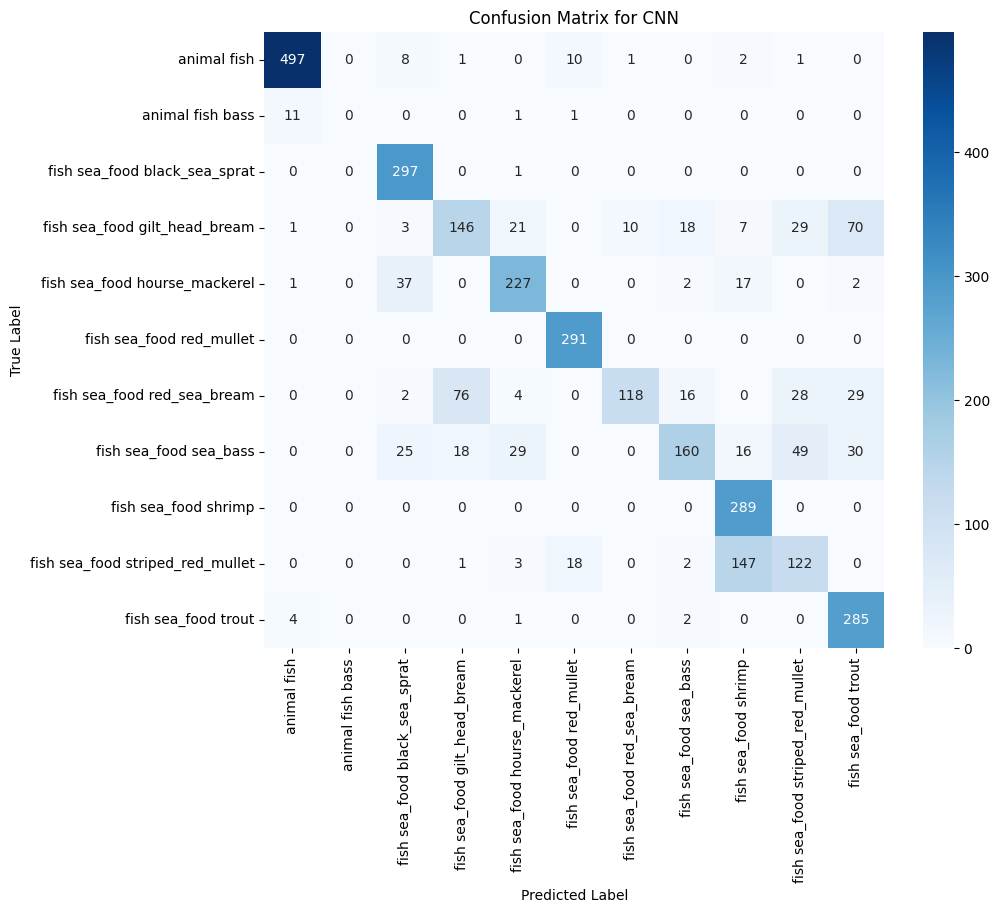

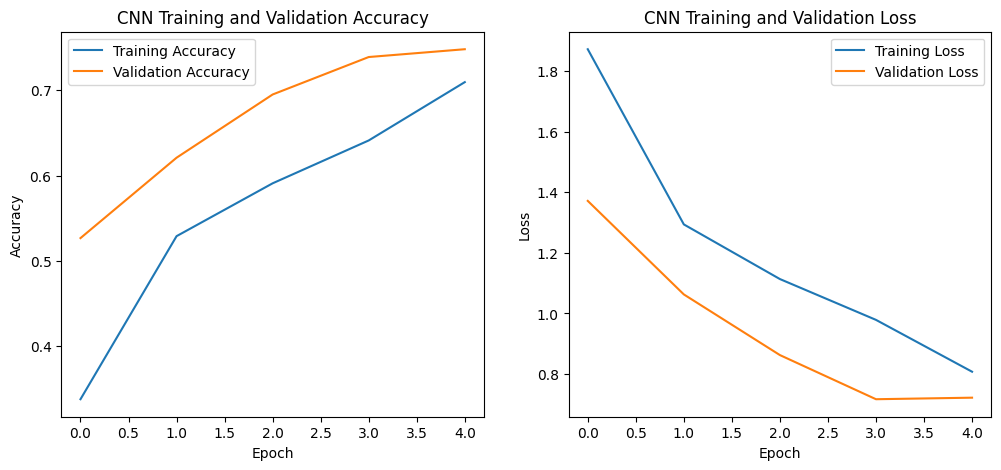


--- Evaluating VGG16 on Test Data ---
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 229ms/step
Classification Report for VGG16:
                                  precision    recall  f1-score   support

                     animal fish       0.98      0.98      0.98       520
                animal fish bass       0.75      0.23      0.35        13
   fish sea_food black_sea_sprat       0.95      0.99      0.97       298
   fish sea_food gilt_head_bream       0.97      0.96      0.97       305
   fish sea_food hourse_mackerel       0.91      1.00      0.95       286
        fish sea_food red_mullet       0.92      0.95      0.93       291
     fish sea_food red_sea_bream       1.00      0.96      0.98       273
          fish sea_food sea_bass       0.97      0.98      0.97       327
            fish sea_food shrimp       0.86      1.00      0.92       289
fish sea_food striped_red_mullet       0.98      0.69      0.81       293
             fish sea_food trout       0.97      1.00      0.98      

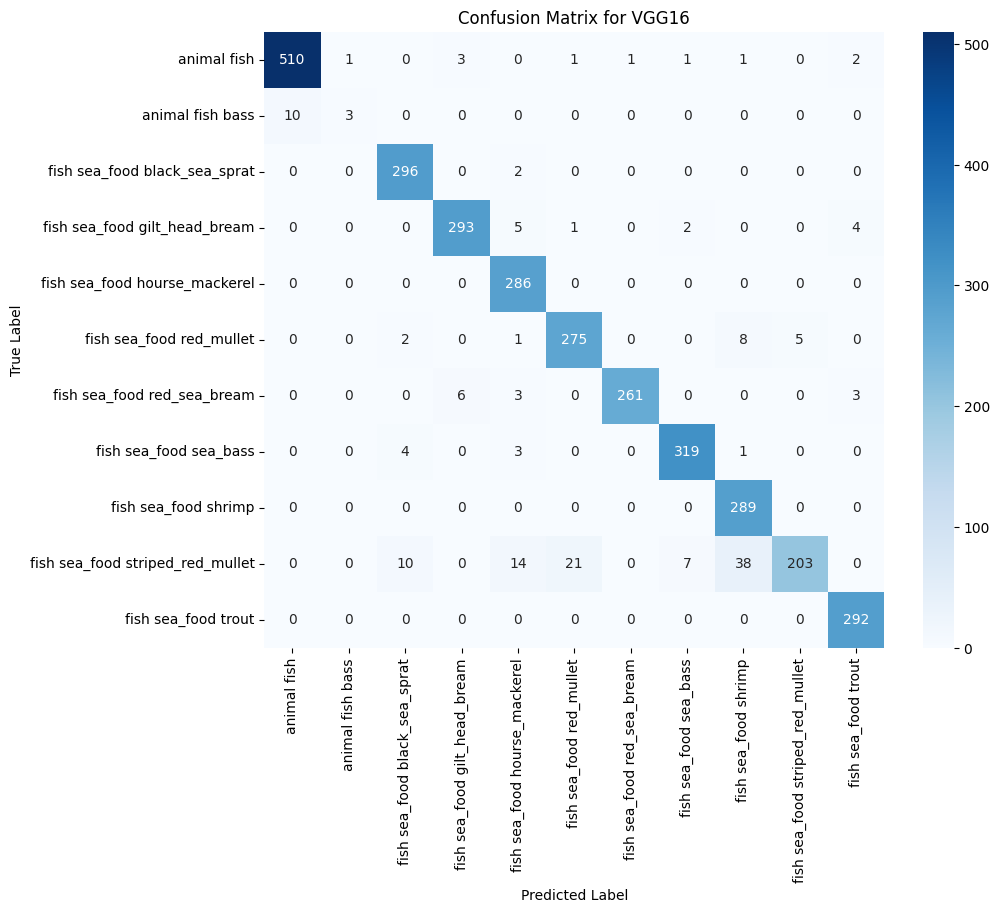

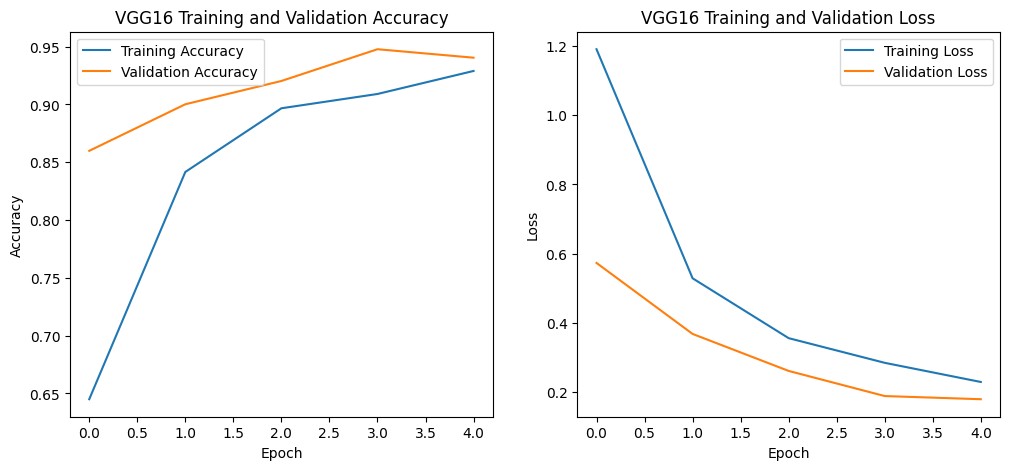


--- Evaluating ResNet50 on Test Data ---
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 138ms/step
Classification Report for ResNet50:
                                  precision    recall  f1-score   support

                     animal fish       0.38      0.81      0.52       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.30      0.17      0.22       298
   fish sea_food gilt_head_bream       0.04      0.00      0.01       305
   fish sea_food hourse_mackerel       0.27      0.08      0.12       286
        fish sea_food red_mullet       0.29      0.44      0.35       291
     fish sea_food red_sea_bream       0.00      0.00      0.00       273
          fish sea_food sea_bass       0.61      0.06      0.11       327
            fish sea_food shrimp       0.42      0.16      0.23       289
fish sea_food striped_red_mullet       0.27      0.25      0.26       293
             fish sea_food trout       0.23      0.77      0.36

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


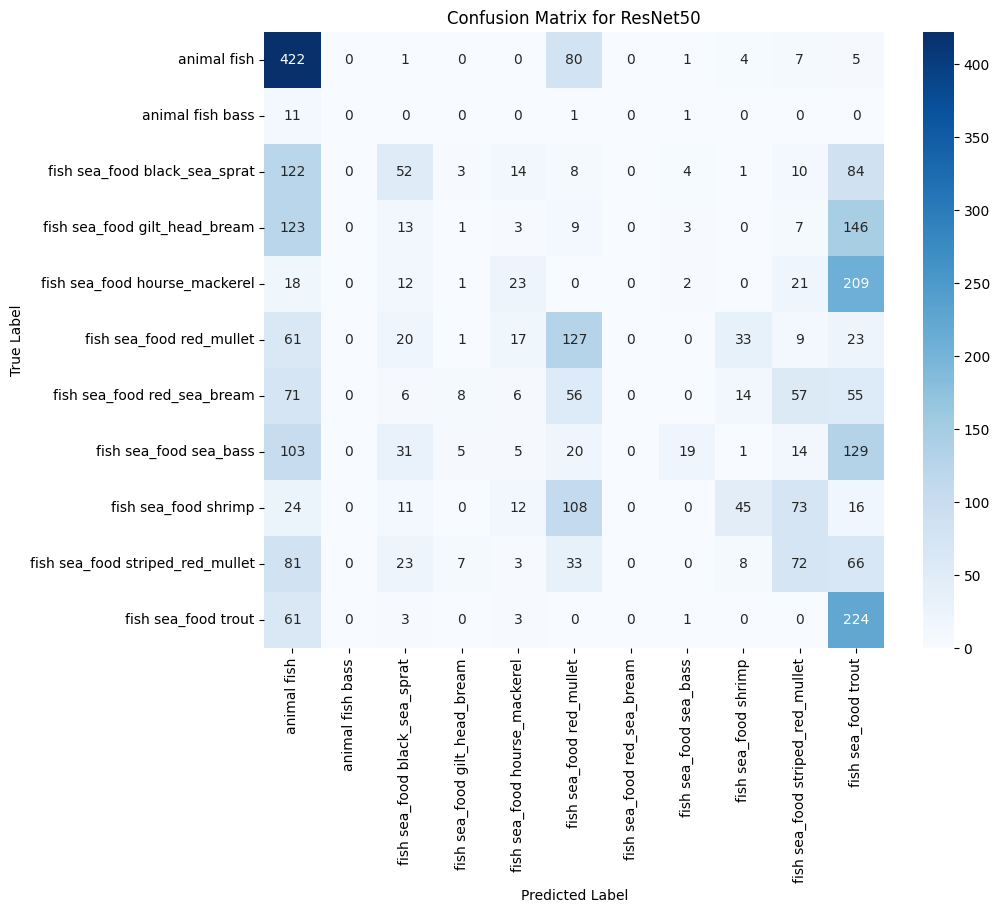

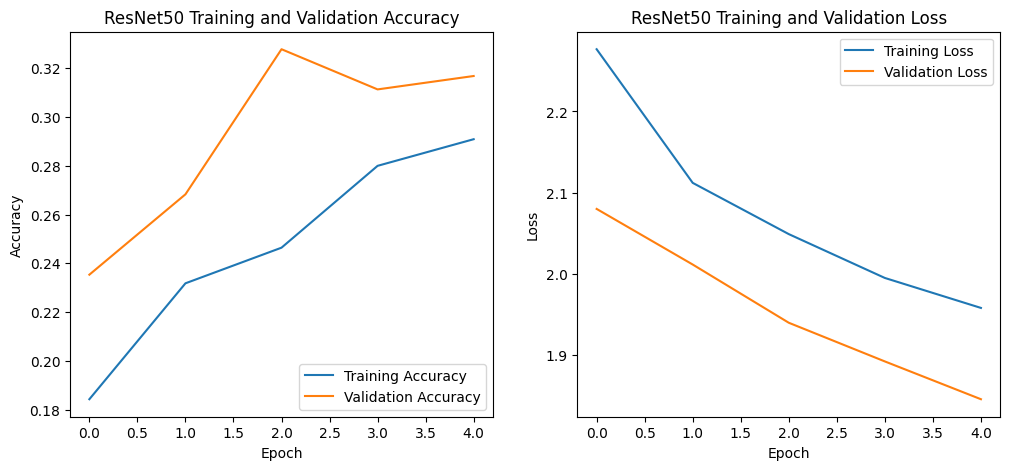


--- Evaluating MobileNet on Test Data ---
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step
Classification Report for MobileNet:
                                  precision    recall  f1-score   support

                     animal fish       1.00      1.00      1.00       520
                animal fish bass       1.00      0.85      0.92        13
   fish sea_food black_sea_sprat       0.99      1.00      0.99       298
   fish sea_food gilt_head_bream       1.00      0.96      0.98       305
   fish sea_food hourse_mackerel       0.99      1.00      1.00       286
        fish sea_food red_mullet       0.99      1.00      0.99       291
     fish sea_food red_sea_bream       0.96      1.00      0.98       273
          fish sea_food sea_bass       0.99      1.00      1.00       327
            fish sea_food shrimp       1.00      1.00      1.00       289
fish sea_food striped_red_mullet       0.99      0.99      0.99       293
             fish sea_food trout       1.00      1.00      1.

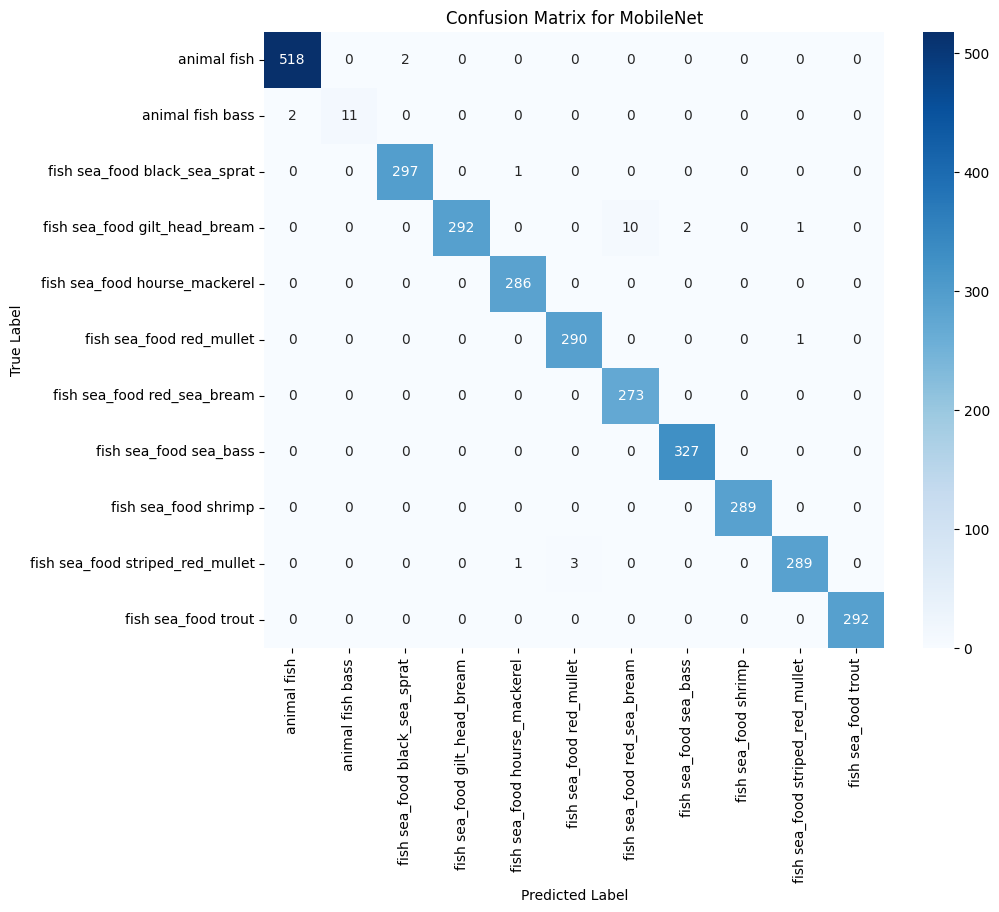

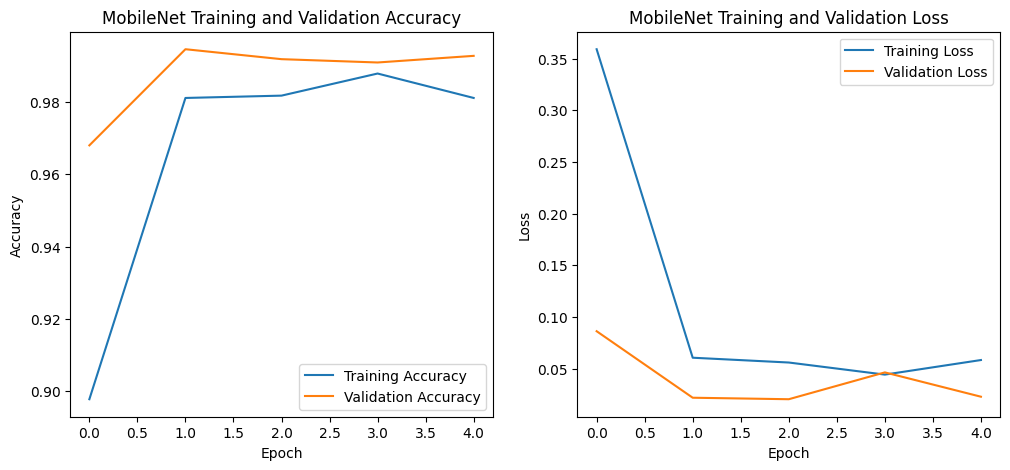


--- Evaluating InceptionV3 on Test Data ---
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 156ms/step
Classification Report for InceptionV3:
                                  precision    recall  f1-score   support

                     animal fish       0.98      0.99      0.98       520
                animal fish bass       1.00      0.54      0.70        13
   fish sea_food black_sea_sprat       1.00      0.93      0.97       298
   fish sea_food gilt_head_bream       0.99      0.99      0.99       305
   fish sea_food hourse_mackerel       0.98      0.98      0.98       286
        fish sea_food red_mullet       1.00      0.93      0.96       291
     fish sea_food red_sea_bream       1.00      0.99      1.00       273
          fish sea_food sea_bass       0.96      0.97      0.96       327
            fish sea_food shrimp       0.98      1.00      0.99       289
fish sea_food striped_red_mullet       0.89      0.97      0.93       293
             fish sea_food trout       0.98      1.00    

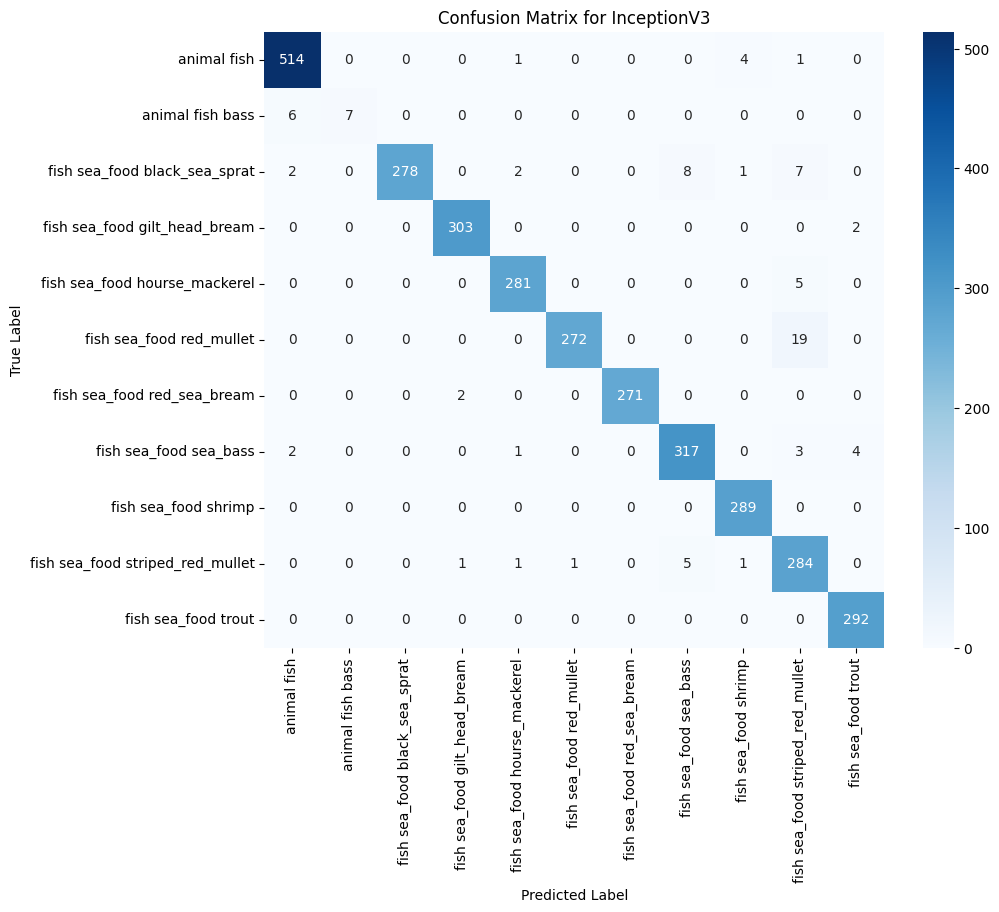

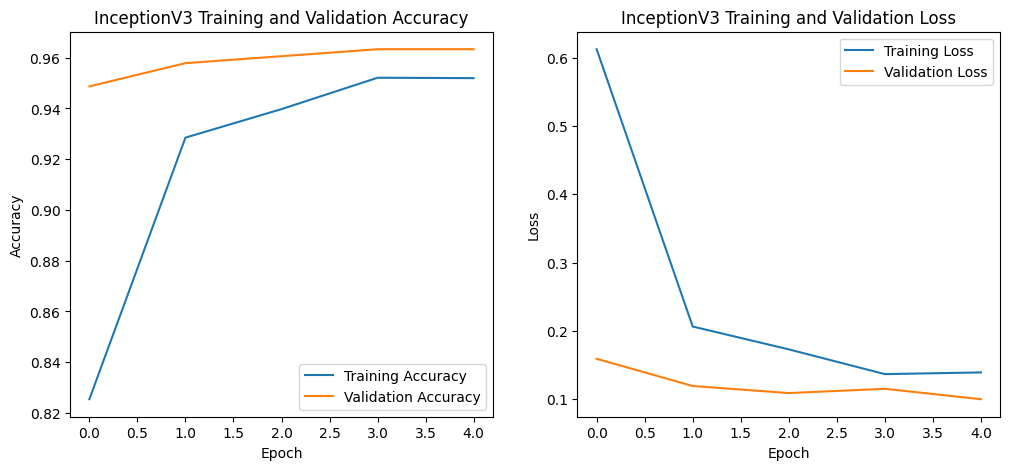


--- Evaluating EfficientNetB0 on Test Data ---
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 173ms/step
Classification Report for EfficientNetB0:
                                  precision    recall  f1-score   support

                     animal fish       0.16      1.00      0.28       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.00      0.00      0.00       298
   fish sea_food gilt_head_bream       0.00      0.00      0.00       305
   fish sea_food hourse_mackerel       0.00      0.00      0.00       286
        fish sea_food red_mullet       0.00      0.00      0.00       291
     fish sea_food red_sea_bream       0.00      0.00      0.00       273
          fish sea_food sea_bass       0.00      0.00      0.00       327
            fish sea_food shrimp       0.00      0.00      0.00       289
fish sea_food striped_red_mullet       0.00      0.00      0.00       293
             fish sea_food trout       0.00      0.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


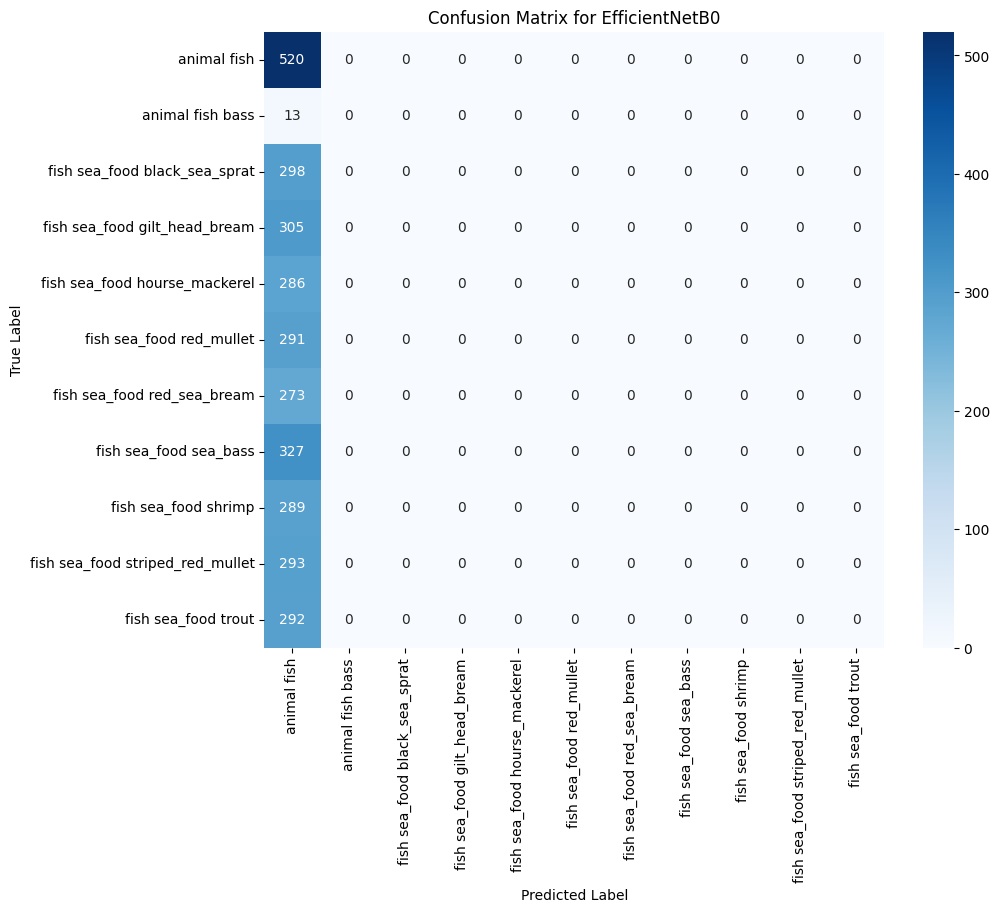

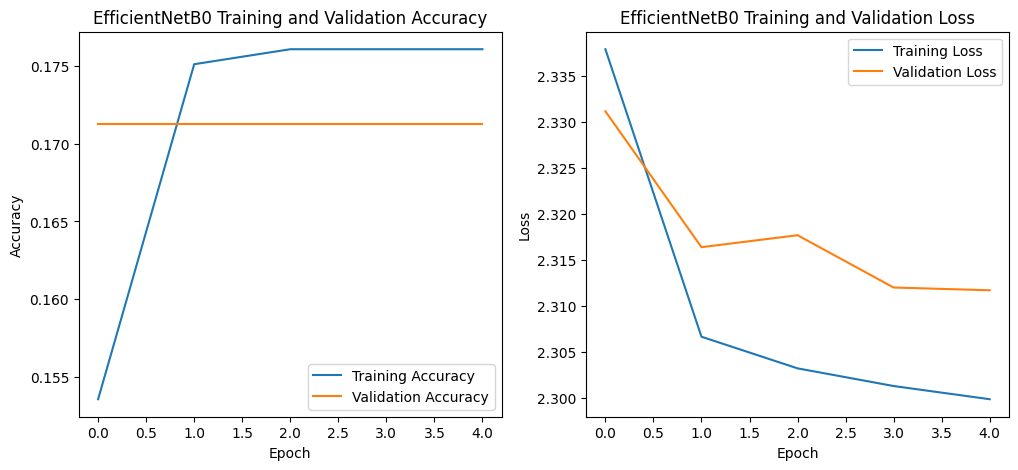

In [14]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, test_gen, model_name):
    print(f"\n--- Evaluating {model_name} on Test Data ---")
    test_gen.reset()
    predictions = model.predict(test_gen)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_gen.classes

    # Classification Report
    report = classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys()))
    print(f"Classification Report for {model_name}:\n{report}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Run evaluation on all trained models
all_models = {'CNN': cnn_model, **trained_models}
all_histories = {'CNN': history_cnn, **trained_histories}

for name, model in all_models.items():
    evaluate_model(model, test_generator, name)
    plot_training_history(all_histories[name], name)